In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Compare old and new agricultural inputs from NIBIO

NIBIO have provided regine-level estimates for agricultural nutrient losses for 2021 (see e-mail from Sigrun received 10.01.2024 at 16.31).

This notebook compares the new NIBIO results to those previously provided by Hans Olav for TEOTIL2.

## 1. Create spatial data for "fylker-soner"

TEOTIL2 grouped agricultural inputs according to "fylker-soner". Unfortunately, no-one knows exactly where these come from and I don't have a spatial dataset representing their extent. However, the TEOTIL2 input file [here](https://github.com/NIVANorge/teotil2/blob/main/data/core_input_data/regine_fysone.csv) maps regine IDs (from the old regine dataset) to `fylke_sone`. I can therefore "reverse engineer" the fylker-soner spatial data by "dissolving" the old regine polygons from TEOTIL2.

In [2]:
# Get a table linking TEOTIL2 regines to 'fylke-sone'
url = "https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/core_input_data/regine_fysone.csv"
df = pd.read_csv(url, sep=";")
df.head()

,regine,fylke_sone
0,001.10,1_1
1,001.1A1,1_1
2,001.1A20,1_1
3,001.1A2A,1_1
4,001.1A2B,1_1


,fylke_sone,geometry
0,10_1,"POLYGON ((7673.760 6463055.350, 7137.490 64633..."
1,10_2,"MULTIPOLYGON (((15365.190 6507109.940, 15383.1..."
2,11_1,"POLYGON ((-31307.030 6522885.680, -31266.010 6..."
3,11_2,"POLYGON ((-17132.610 6568172.920, -17229.400 6..."
4,11_3,"POLYGON ((-25296.500 6506558.810, -25849.810 6..."


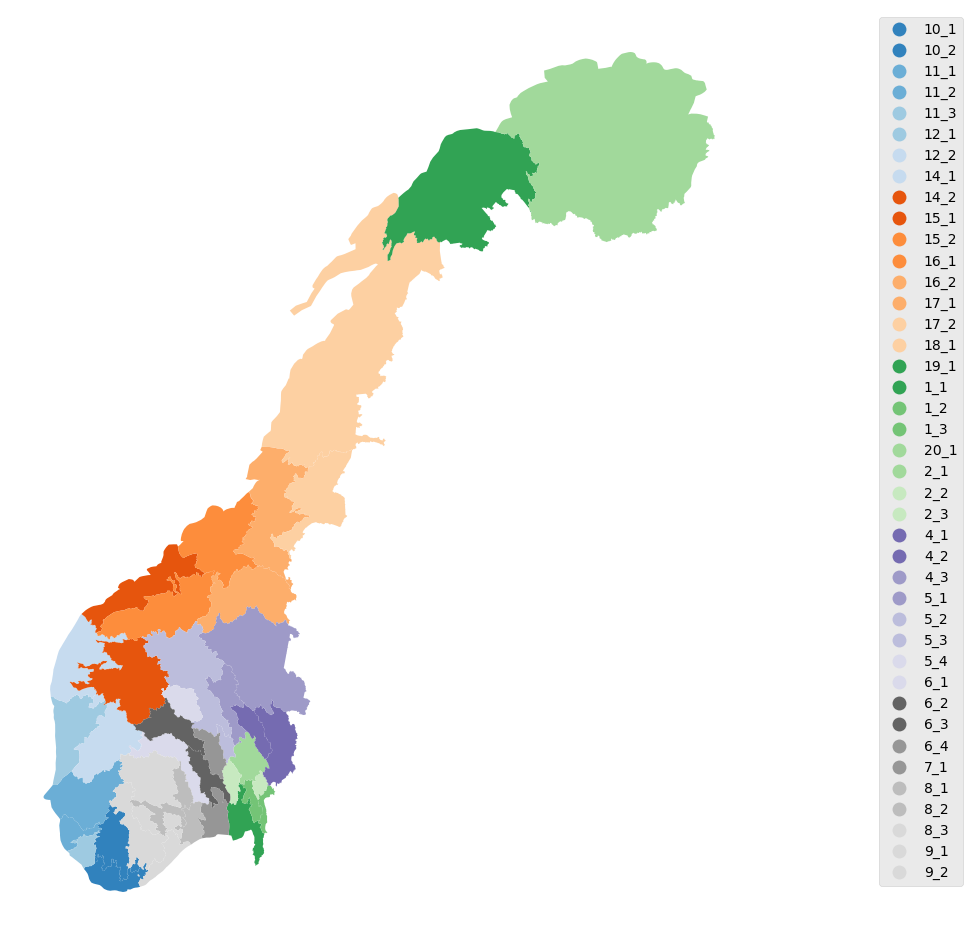

In [3]:
# Read TEOTIL2 regines
fyso_gdf = gpd.read_file(
    r"/home/jovyan/shared/common/JES/teotil2/data/core_input_data/gis/reg_minste_f_wgs84.shp"
)

# Dissolve
fyso_gdf = (
    fyso_gdf.merge(df, left_on="VASSDRAGNR", right_on="regine", how="left")
    .dissolve(by="fylke_sone")
    .reset_index()
).to_crs("epsg:25833")

# Plot
ax = fyso_gdf.plot(
    column="fylke_sone",
    categorical=True,
    legend=True,
    cmap="tab20c",
    figsize=(12, 12),
    legend_kwds={"bbox_to_anchor": (1.3, 1)},
)
ax.axis("off")

fyso_gdf = fyso_gdf[["fylke_sone", "geometry"]]
fyso_gdf.head()

## 2. Assign new regines to "fylker-soner"

I can now intersect the "fylke-sone" dataset with the *new* regines. I will assign each regine in the new dataset to the `fylke-sone` that covers the largest proportion of the polygon's area.

In [4]:
# Read TEOTIL3 regines
spatial_data_fold = f"/home/jovyan/shared/common/teotil3/core_data"
teo_gpkg = os.path.join(spatial_data_fold, "tidied", f"teotil3_data.gpkg")
reg_gdf = gpd.read_file(teo_gpkg, layer=f"regines", driver="GPKG").to_crs("epsg:25833")
reg_gdf = reg_gdf[["regine", "geometry"]]

# Intersect new regines with fylker-soner and calculate areas
int_gdf = gpd.overlay(reg_gdf, fyso_gdf, how="intersection")
int_gdf["area_km2"] = int_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6

# Link each regine to the dominant flyke-sone
agg = int_gdf.groupby("regine")["area_km2"].idxmax()
link_df = int_gdf.loc[agg][["regine", "fylke_sone"]]

# Join results back to original regines
reg_gdf = reg_gdf.merge(link_df, how="left", on="regine")
reg_gdf["fylke_sone"].fillna("None", inplace=True)

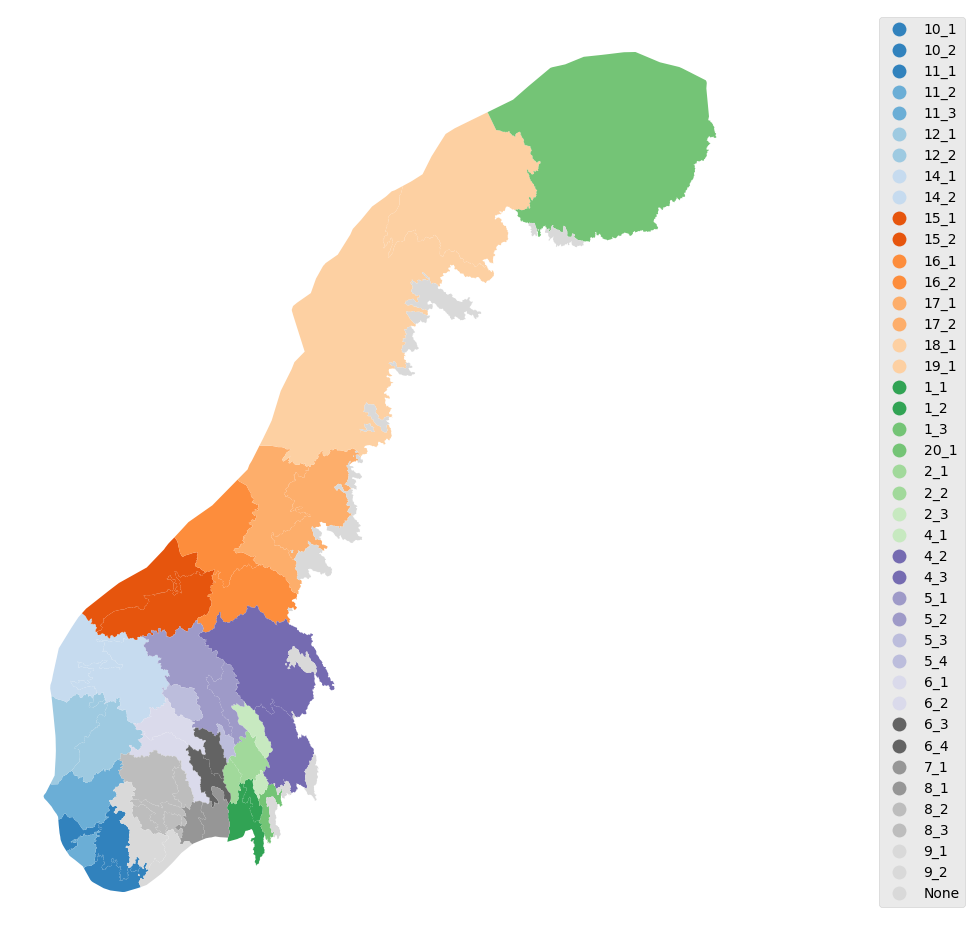

In [5]:
# Check results look OK
fyso_gdf2 = reg_gdf.dissolve(by="fylke_sone").reset_index()

ax = fyso_gdf2.plot(
    column="fylke_sone",
    categorical=True,
    legend=True,
    cmap="tab20c",
    figsize=(12, 12),
    legend_kwds={"bbox_to_anchor": (1.3, 1)},
)
ax.axis("off");

## 3. Compare agricultural estimates

I now have a dataset assigning each of the new regine to the old fylker-soner. This makes it easy to compare the old and new results from NIBIO at the level of fylker-soner.

In [6]:
year = 2021

In [7]:
# Read new NIBIO data
xl_path = f"/home/jovyan/shared/common/teotil3/agri_data/nibio_agri_data_{year}.xlsx"
new_df = pd.read_excel(xl_path, sheet_name="Annual loss", skiprows=[1])

# Get columns of interest and rename
names_dict = {
    "Regine unit": "regine",
    "TN netto annual loss": "n_diff_kg",
    "TN bakgrunnsavr. annual loss": "n_back_kg",
    "TP netto annual loss": "p_diff_kg",
    "TP bakgrunnsavr. annual loss": "p_back_kg",
}
new_df.rename(columns=names_dict, inplace=True)
new_df = new_df[names_dict.values()]

# Join to regines and aggregate to 'fylke-sone'
reg_gdf = reg_gdf.merge(new_df, how="left", on="regine")
agg_df = reg_gdf.groupby("fylke_sone").sum(numeric_only=True).reset_index()
agg_df.head()

,fylke_sone,n_diff_kg,n_back_kg,p_diff_kg,p_back_kg
0,10_1,7.685666e+05,85396.293314,17569.806270,2163.582176
1,10_2,6.196568e+05,68850.754448,13627.703398,1797.758155
2,11_1,2.721614e+06,302401.599325,74647.199831,6903.299652
3,11_2,2.504609e+06,278237.769498,72109.175608,8102.606178
4,11_3,8.603545e+05,95547.787388,22783.736158,3190.395670


In [8]:
# Get the old NIBIO data for comparison
xl_path = f"/home/jovyan/shared/common/JES/teotil2_data/agri_data/jordbruk_{year}.xlsx"
old_df = pd.read_excel(xl_path, sheet_name=f"jordbruk_{year}")

# Map region codes to fylke-sone
url = r"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/core_input_data/fysone_land_areas.csv"
code_df = pd.read_csv(url, sep=";", encoding="cp1252")[["omrade", "fylke_sone"]]
old_df = pd.merge(old_df, code_df, how="left", on="omrade")
del old_df["omrade"]

# Join old and new datasets
comp_df = pd.merge(
    old_df, agg_df, how="left", on="fylke_sone", suffixes=("_old", "_new")
)
comp_df.head()

,n_diff_kg_old,n_point_kg,n_back_kg_old,p_diff_kg_old,p_point_kg,p_back_kg_old,fylke_sone,n_diff_kg_new,n_back_kg_new,p_diff_kg_new,p_back_kg_new
0,739312,8338,157590,50055,674,3563,1_1,1.786746e+06,198527.311349,92882.982014,4280.145875
1,1160956,5451,194922,25004,457,3422,1_2,1.144376e+06,127152.925129,108792.844099,3920.165416
2,223248,1048,39159,6990,90,759,1_3,2.118582e+05,23539.800755,8048.525753,611.512710
3,1608982,9164,237631,81335,1470,5554,2_1,1.898976e+06,210997.372097,127907.431674,5106.671547
4,757050,1905,117703,29993,245,2221,2_2,5.802417e+05,64471.301029,31757.603401,1580.677291


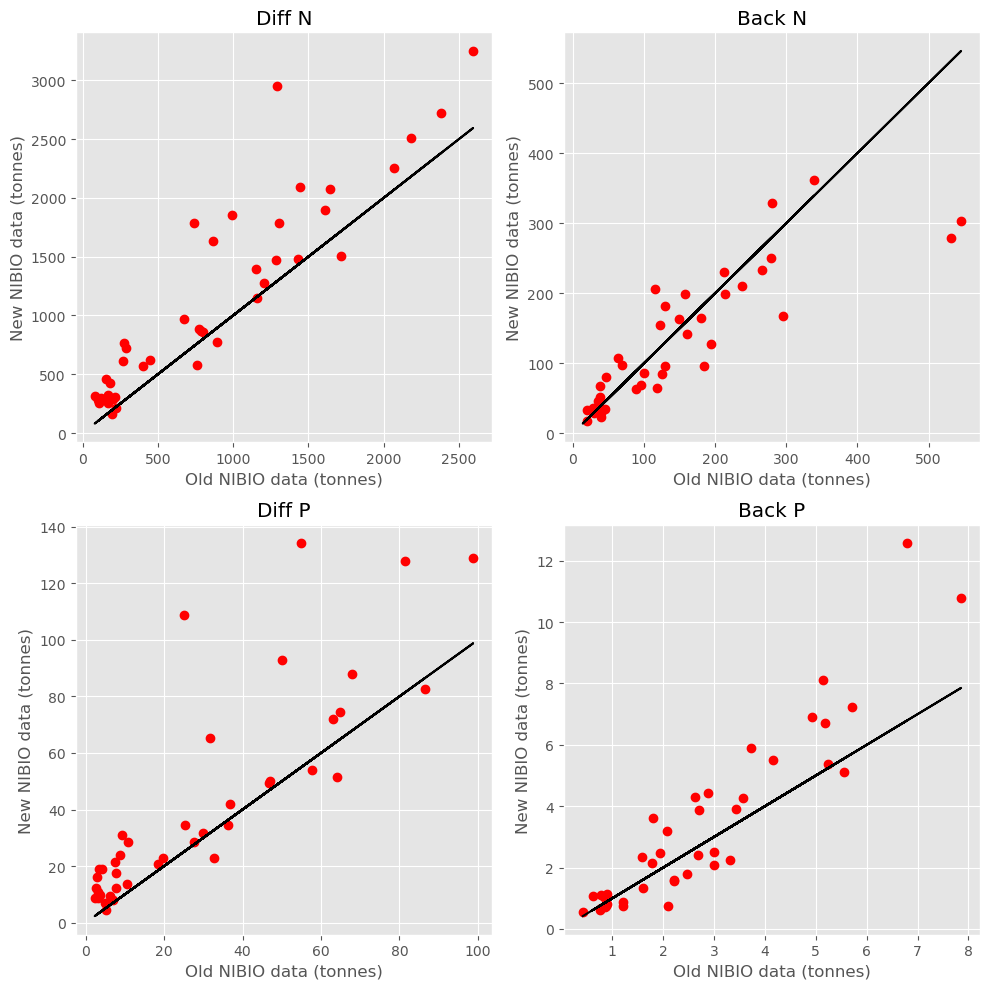

In [9]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for row_idx, par in enumerate(("n", "p")):
    for col_idx, src in enumerate(("diff", "back")):
        axes[row_idx, col_idx].plot(
            comp_df[f"{par}_{src}_kg_old"] / 1000,
            comp_df[f"{par}_{src}_kg_new"] / 1000,
            "ro",
        )
        axes[row_idx, col_idx].plot(
            comp_df[f"{par}_{src}_kg_old"] / 1000,
            comp_df[f"{par}_{src}_kg_old"] / 1000,
            "k-",
            label="1:1 line",
        )
        axes[row_idx, col_idx].set_xlabel("Old NIBIO data (tonnes)")
        axes[row_idx, col_idx].set_ylabel("New NIBIO data (tonnes)")
        axes[row_idx, col_idx].set_title(f"{src.capitalize()} {par.capitalize()}")
plt.tight_layout()

In [10]:
df_list = []
for year in range(2016, 2023):
    # Read new NIBIO data
    xl_path = (
        f"/home/jovyan/shared/common/teotil3/agri_data/nibio_agri_data_{year}.xlsx"
    )
    new_df = pd.read_excel(xl_path, sheet_name="Annual loss", skiprows=[1])

    # Get columns of interest and rename
    names_dict = {
        "TN netto annual loss": "n_kg",
        "TP netto annual loss": "p_kg",
    }
    new_df.rename(columns=names_dict, inplace=True)
    new_df = new_df[names_dict.values()].sum().to_frame().T
    new_df["year"] = year

    # Read old NIBIO data
    if year in (2018, 2019, 2020):
        xl_path = f"/home/jovyan/shared/common/JES/teotil2_data/agri_data/jordbruk_{year}_corr2022_v3.xlsx"
    else:
        xl_path = f"/home/jovyan/shared/common/JES/teotil2_data/agri_data/jordbruk_{year}.xlsx"
    old_df = pd.read_excel(xl_path, sheet_name=f"jordbruk_{year}")
    old_df["n_kg"] = old_df["n_diff_kg"] + old_df["n_point_kg"]
    old_df["p_kg"] = old_df["p_diff_kg"] + old_df["p_point_kg"]
    old_df = old_df[names_dict.values()].sum().to_frame().T
    old_df["year"] = year

    df = pd.merge(old_df, new_df, how="left", on="year", suffixes=["_old", "_new"])
    df_list.append(df)
df = pd.concat(df_list, axis="rows").set_index("year")
df = df / 1000
df

,n_kg_old,p_kg_old,n_kg_new,p_kg_new
year,,,,
2016,34031.242,1184.907,44973.639737,1649.547089
2017,34084.636,1167.395,50104.269419,1787.270016
2018,36615.433,1209.608,57470.424546,1798.694874
2019,36472.326,1197.863,50056.673148,1779.881971
2020,36555.849,1204.967,59129.601934,1998.438362
2021,36674.843,1244.629,46903.030093,1697.944447
2022,36542.834,1217.043,49869.628499,1765.228588


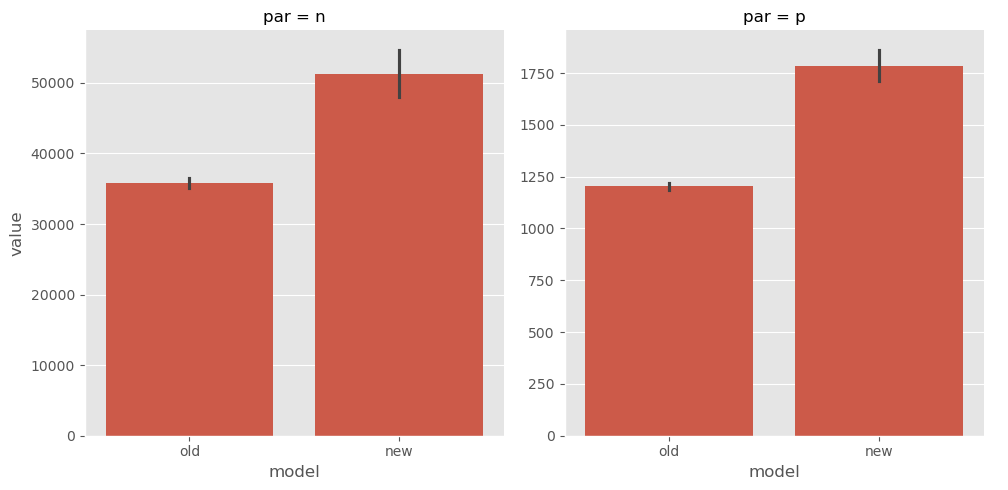

In [11]:
df2 = df.melt()
df2["par"] = df2["variable"].str.split("_").str[0]
df2["model"] = df2["variable"].str.split("_").str[-1]
sn.catplot(data=df2, x="model", y="value", col="par", kind="bar", sharey=False)

In [13]:
df['n_kg_new'].sum() / df['n_kg_old'].sum() 

1.4284457720728632

In [14]:
df['p_kg_new'].sum() / df['p_kg_old'].sum() 

1.4807020292032718

## 4. Summary

 * There is a generally positive correlation between the old and new agricultural data supplied by NIBIO, which is good!
 
 * Agricultural losses have generally increased, and the change is quite large for TOTP in some areas.